<a href="https://colab.research.google.com/github/abhaswanchu1/mids-281-final-project-cars/blob/Abhas-Work/Processing_filtered_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://PERSONALACCESSTOKEN@github.com/abhaswanchu1/mids-281-final-project-cars.git

fatal: destination path 'mids-281-final-project-cars' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: load filtered_df from a pkl file

import pandas as pd
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, match_template
start_time = time.time()
try:
  filtered_df = pd.read_pickle('drive/MyDrive/filtered_df.pkl')
  print("Successfully loaded filtered_df.")
except FileNotFoundError:
  print("Error: filtered_df.pkl not found. Please check the file path.")
except Exception as e:
  print(f"An error occurred: {e}")
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")


Successfully loaded filtered_df.
Time taken: 8.06813645362854 seconds


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.3, random_state=42,stratify=filtered_df['brand'])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python

In [ ]:
filtered_df.head()

,image_path,brand,image
0,drive/MyDrive/cars_dataset/Chevrolet/07068.jpg,Chevrolet,"[[[59, 61, 61], [59, 61, 61], [59, 61, 61], [5..."
1,drive/MyDrive/cars_dataset/Chevrolet/07075.jpg,Chevrolet,"[[[220, 200, 175], [221, 201, 176], [221, 201,..."
2,drive/MyDrive/cars_dataset/Chevrolet/07077.jpg,Chevrolet,"[[[169, 130, 128], [193, 156, 152], [210, 174,..."
3,drive/MyDrive/cars_dataset/Chevrolet/07085.jpg,Chevrolet,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,drive/MyDrive/cars_dataset/Chevrolet/07089.jpg,Chevrolet,"[[[199, 130, 80], [202, 133, 83], [202, 133, 8..."


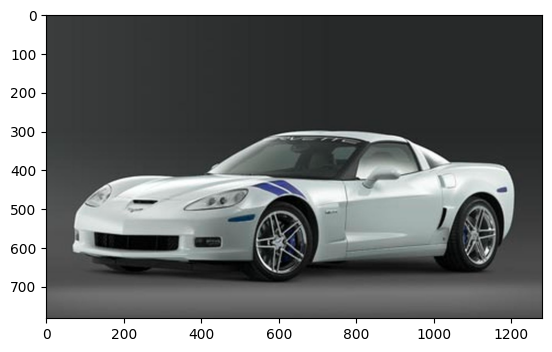

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

plt.imshow(train_df['image'][0])

In [ ]:
def process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Crop image so that it is square (DONT CHANGE ASPECT RATIO)
    h, w = image.shape
    if h > w:
        image = image[(h - w) // 2:(h + w) // 2, :]
    else:
        image = image[:, (w - h) // 2:(w + h) // 2]
    image = cv2.resize(image, (224, 224))

    return image

In [ ]:
train_df['processed_image'] = train_df['image'].apply(process_image)


In [ ]:
test_df['processed_image'] = test_df['image'].apply(process_image)


In [ ]:
train_images, train_targets = train_df['processed_image'], train_df['brand']
test_images, test_targets = test_df['processed_image'], test_df['brand']

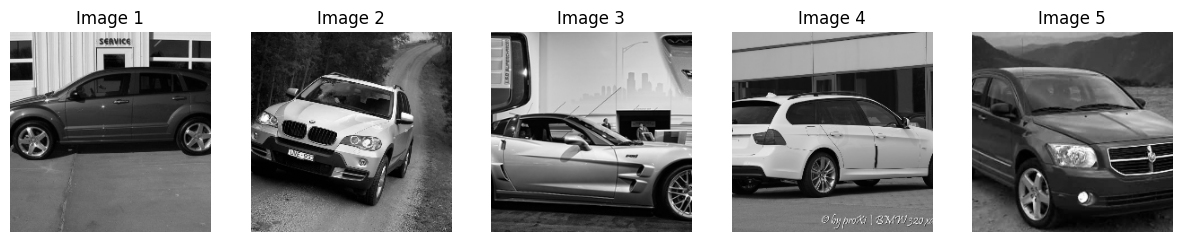

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 1 row, 5 columns

# Loop through the first 5 images and display them in the subplots
for i in range(5):
    axes[i].imshow(train_images.iloc[i], cmap='gray')  # Use cmap='gray' for grayscale images
    axes[i].set_title(f"Image {i + 1}")
    axes[i].axis('off')  # Turn off axis labels

plt.show()

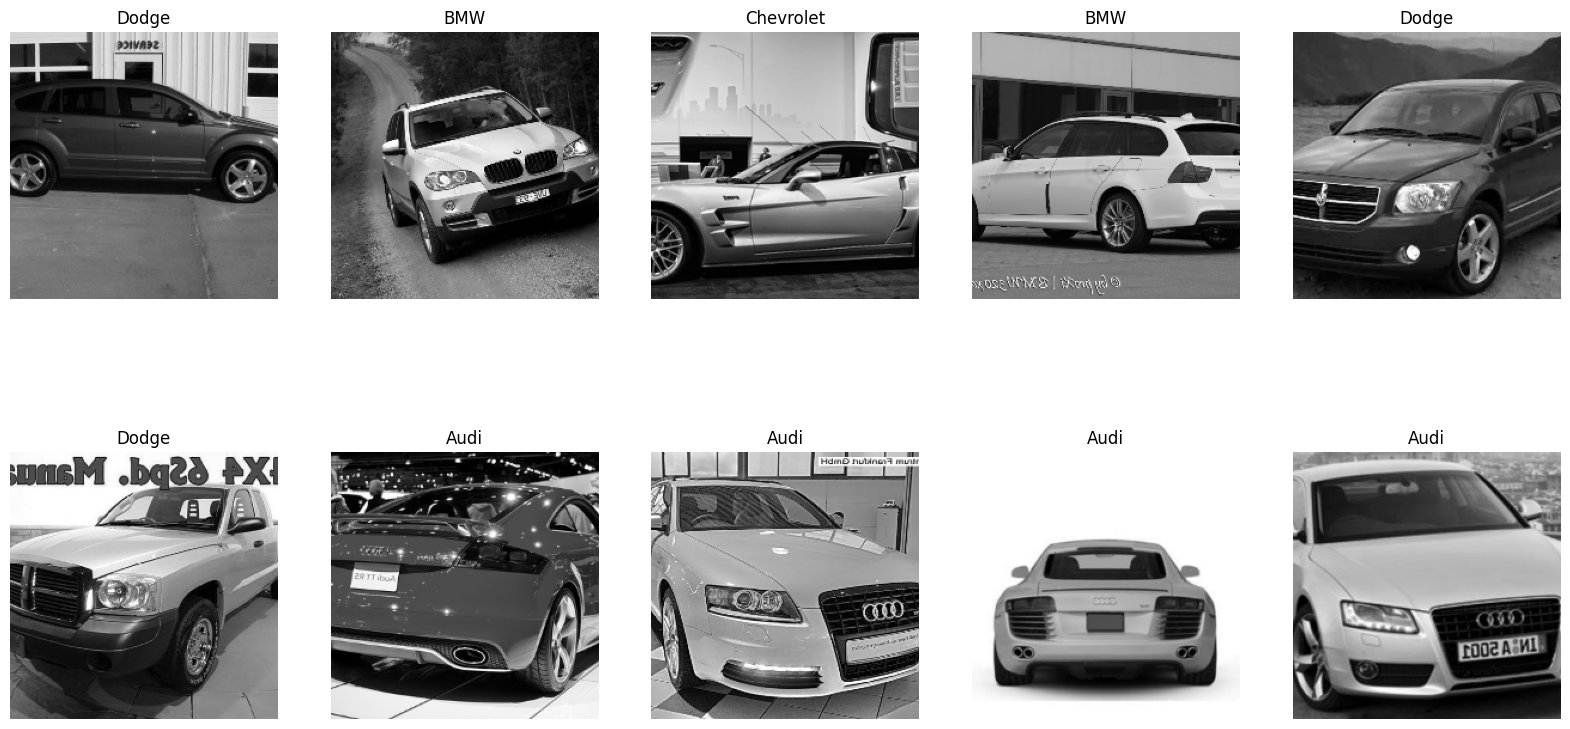

In [ ]:
def augment_images(images, targets):
    # OKAY TO FLIP IMAGES, but rotations and shearing will cause misalignment and probably not help blind
    # Missaligned edges (black space) a problem downstream? YES
    augmented_images = []
    augmented_target = []
    for i in range(len(images)):
        img = images.iloc[i]
        img = cv2.flip(img, 1)
        ### Consider Adding Contrast Normalization if the training data isn't large enough
        augmented_images.append(img)
        augmented_target.append(targets.iloc[i])
    return augmented_images, augmented_target


# # Plot the Augmented Images and their labels
augmented_images, augmented_targets = augment_images(train_images, train_targets)
augmented_images_test, augmented_targets_test = augment_images(test_images, test_targets)

plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i], cmap = 'gray')
    plt.title(augmented_targets[i])
    plt.axis('off')
plt.show()



In [ ]:
train_images = train_images.tolist()  # Convert train_images to a list
train_images.extend(augmented_images)

train_targets = train_targets.tolist()  # Convert train_targets to a list
train_targets.extend(augmented_targets)

test_images = test_images.tolist()  # Convert test_images to a list
test_images.extend(augmented_images_test)

test_targets = test_targets.tolist()  # Convert test_targets to a list
test_targets.extend(augmented_targets_test)

In [ ]:
del (augmented_images, augmented_targets, augmented_images_test, augmented_targets_test)


In [ ]:
from skimage.feature import hog, match_template

def hog_features(images):
    hog_features = []
    for img in images:
        # fd, hog_feature = hog(img, orientations=8, pixels_per_cell=(16, 16), visualize=True,
        #                   cells_per_block=(1, 1), channel_axis=-1) # Uncomment to Plot HOG feature
        hog_feature = hog(img, orientations=8, pixels_per_cell=(16, 16),
                           cells_per_block=(1, 1))
        hog_features.append(hog_feature)
    return hog_features


def fourier_features(images):
    fourier_features = []
    [ydim, xdim] = images[0].shape
    win = np.outer(np.hanning(ydim), np.hanning(xdim))
    win = win / np.mean(win)
    for img in images:
        F = np.fft.fftshift(np.fft.fft2(img * win))
        Fmag = np.abs(F)
        fourier_features.append(Fmag)
    return fourier_features


def canny_features(images):
    canny_features = []
    for img in images:
        canny = cv2.Canny(img, 100, 200)
        canny_features.append(canny)
    return canny_features


# Train Features


In [ ]:
hog_train = hog_features(train_images)


In [ ]:
fourier_train = fourier_features(train_images)
canny_train = canny_features(train_images)



In [ ]:
# Test Features
hog_test = hog_features(test_images)
fourier_test = fourier_features(test_images)
canny_test = canny_features(test_images)

In [ ]:
def stack_rows(features):
    '''
    Efficiently stacks multiple lists of image features row-wise.
    For each image i, flattens all features and concatenates them into a single row.
    Returns a 2D numpy array.
    '''
    stacked = np.array([
        np.concatenate([feature[i].flatten() for feature in features])
        for i in range(len(features[0]))
    ])
    return stacked


stacked_features = stack_rows([hog_train, fourier_train, canny_train])
stacked_features_test = stack_rows([hog_test, fourier_test, canny_test])


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Normalize the stacked features
scaler = StandardScaler()
scaler.fit(stacked_features)
stacked_features = scaler.transform(stacked_features)
stacked_features_test = scaler.transform(stacked_features_test)

# Save stacked_features
np.save(r'drive/MyDrive/stacked_features.npy', stacked_features)

# Save stacked_features_test
np.save(r'drive/MyDrive/stacked_features_test.npy', stacked_features_test)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

n_components = 2000
pca = PCA(n_components=0.95)
pca.fit(stacked_features)
X_train = pca.transform(stacked_features)
X_test = pca.transform(stacked_features_test)

# Trim X to the number of components that explain 90% of the variance
X_train = X_train[:, :n_components]
X_test = X_test[:, :n_components]


# Save out X, X_test, Targets, and Test_Targets as numpy arrays
np.save(r"drive/MyDrive/X.npy", X_train)
np.save(r"drive/MyDrive/X_test.npy", X_test)
np.save(r"drive/MyDrive/targets.npy", train_targets)
np.save(r"drive/MyDrive/test_targets.npy", test_targets)

In [ ]:
# Save out the PCA model
with open(r"drive/MyDrive/PCA.pkl", "wb") as f:
    pickle.dump(pca, f)

In [ ]:
with open(r"drive/MyDrive/PCA.pkl", "rb") as f:
    pca = pickle.load(f)

X = pca.transform(stacked_features)
X_test = pca.transform(stacked_features_test)

# Trim X to the number of components that explain 90% of the variance
n_components = 2000
X = X[:, :n_components]
X_test = X_test[:, :n_components]